In [12]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.optimizers import Adam
import os
import itertools
from tqdm import tqdm
from PIL import Image


In [14]:
image_size = (224,224)

In [13]:
ela_real="/home/sky/Documents/ml/yash/image_forgery/new/resized_images/fake_images/"
ela_fake="/home/sky/Documents/ml/yash/image_forgery/new/resized_images/pristine_images/"


X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1
    if(j==1500):
        break
j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1
    if(j==1500):
        break

 60%|██████████████████████▊               | 1499/2497 [00:01<00:01, 957.32it/s]


In [15]:
X=np.array(X)
X.shape

(3000, 224, 224, 3)

In [16]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=133,shuffle=True)
y_train=to_categorical(y_train,2)
y_dev=to_categorical(y_dev,2)

In [19]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG19
#from keras.preprocessing import image

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
#x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
x = Dense(2, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


80134624/80134624 [==============================] - 81s 1us/step


In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
epochs = 5
batch_size = 20

hist = model.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                verbose=1,shuffle=True)

Epoch 1/5


2023-03-20 00:00:42.541764: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 361267200 exceeds 10% of free system memory.
2023-03-20 00:00:43.515003: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2023-03-20 00:00:43.533407: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2023-03-20 00:00:43.830540: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2023-03-20 00:00:44.671116: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.


75/75 [==============================] - 756s 10s/step - loss: 13.1217 - accuracy: 0.5867 - val_loss: 13.8338 - val_accuracy: 0.6100
Epoch 2/5
75/75 [==============================] - 909s 12s/step - loss: 5.6293 - accuracy: 0.8050 - val_loss: 13.4611 - val_accuracy: 0.6500
Epoch 3/5
75/75 [==============================] - 1035s 14s/step - loss: 4.2610 - accuracy: 0.8687 - val_loss: 16.2392 - val_accuracy: 0.6433
Epoch 4/5
75/75 [==============================] - 1042s 14s/step - loss: 3.7791 - accuracy: 0.8921 - val_loss: 17.7525 - val_accuracy: 0.6333
Epoch 5/5
75/75 [==============================] - ETA: 0s - loss: 3.5845 - accuracy: 0.8988 

In [ ]:
model.save('/home/sky/Documents/ml/yash/image_forgery/new/vgg19_model.h5')

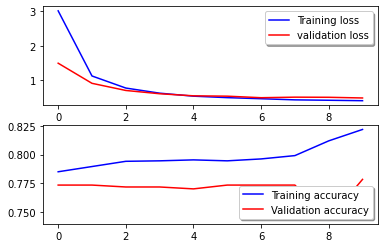

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    


In [26]:
pred=model.predict(x_dev)

19/19 [==============================] - 24s 1s/step


In [ ]:
# pred[0:20]

19/19 [==============================] - 22s 1s/step


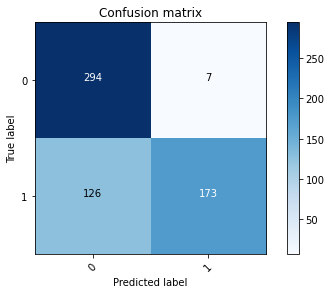

In [31]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_dev)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_dev,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

Prediction

In [36]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras

In [37]:
model = keras.models.load_model('../model.h5') #model path

/tmp/ipykernel_16062/291451910.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image=real_image_path.resize((224, 224), PIL.Image.ANTIALIAS)


1/1 [==============================] - 1s 796ms/step
Class: fake


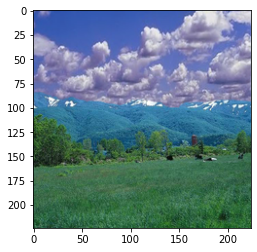

In [38]:
class_names = ['real','fake']
real_image_path = Image.open('') # image path
image=real_image_path.resize((224, 224), PIL.Image.ANTIALIAS)
plt.imshow(image)
image=np.array(image)
image = image.reshape(-1, 224, 224, 3)
# image=np.array(image)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]}')
